# Bus Parameter Validation

In this notebook we validate the electric bus parameters we'll input to FASTSim. This must be done before we can trust our FASTSim CDMX bus route simulation outputs.

We don't have a lot of great options to validate our simulation output against experimental results, so we'll compare our simulation results to the simulation results from the 2021 LOGIOS study of electrifying bus routes in Mexicali.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
from fastsim import simdrive, vehicle, cycle
import utils
utils.run_tests()

## The hybrid Yutong/Logios Bus Parameters

In [3]:
# Highlight the parameter differences between the yutong bus parameters and the newer 
# parameters we're using to approximate the buses used by LOGIOS in their report.
vehicles_df = pd.read_csv(Path('./bus.csv'))
yutong = vehicles_df.iloc[0]
logios = vehicles_df.iloc[1]
diff_cols = []
for i in range(len(yutong)):
    if (yutong[i] != logios[i]) and not pd.isnull(yutong[i]):
        diff_cols.append(yutong.index[i])
vehicles_df.filter(diff_cols)

,Selection,Scenario name,frontalAreaM2,gliderKg,cargoKg,maxMotorKw,maxEssKwh,minSoc,maxSoc,auxKw
0,1,Yutong,7.46,10000,5000,350,295,10%,90%,10
1,2,LOGIOS/Yutong,8.50,14050,3600,300,325,0%,100%,0


In [4]:
bus = vehicle.Vehicle(2, veh_file=Path('./bus.csv'))
bus_jit = bus.get_numba_veh()

## The LOGIOS drive cycle

Route AB03, recorded on 5/20/21.

Processing route AB03, day 0520...
Time to run simulation: 3.64e+01 s
Processing route AB03, day 0521...
Time to run simulation: 2.99e+00 s
Processing route AB03, day 0527...
Time to run simulation: 2.95e+00 s
Processing route AB03, day 0531...
Time to run simulation: 4.13e+00 s
Processing route TC08, day 0525...
Time to run simulation: 2.88e+00 s


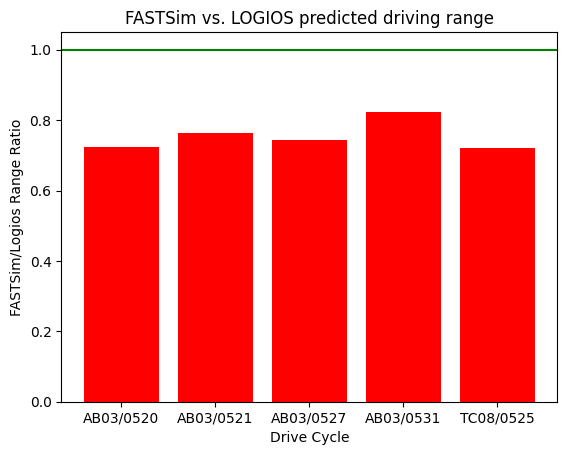

On average, of the 5 simulated drive cycles, FASTSim's simulated range is 75.5% of LOGIOS's


In [5]:
INPUT_PATH = '../Data/LOGIOS Data/Drive Cycles'
routes_and_days = {
    'AB03': {
        # Days when drive cycle data was collected
        'days': ['0520', '0521', '0527', '0531'],
        
        # LOGIOS-predicted range along this route from 100% to 0% SOC
        'rangeKm': 220,
    },
    'TC08': {
        'days': ['0525'], 
        'rangeKm': 244,
    }
}

# Simulate all distinct (route,day) drive cycles and record results
results = {}
for route_name in routes_and_days.keys():
    route = routes_and_days[route_name]
    for day in route['days']:
        print(f'Processing route {route_name}, day {day}...')
        drive_cycle_path = Path(INPUT_PATH) / route_name / day
        output = utils.run_fastsim(drive_cycle_path, bus_jit)
        output['fastsim_range'] = output['rangeKm']
        output['logios_range'] = route['rangeKm']
        results[f'{route_name}/{day}'] = output

route_days = []
range_diffs = []
for drive_cycle in results.keys():
    route_days.append(drive_cycle)
    fastsim_range = results[drive_cycle]['fastsim_range']
    logios_range = results[drive_cycle]['logios_range']
    range_diffs.append(fastsim_range/logios_range)

plt.bar(route_days, height=range_diffs, color='red')
plt.title('FASTSim vs. LOGIOS predicted driving range');
plt.axhline(1.0, color='green')
plt.xlabel('Drive Cycle');
plt.ylabel('FASTSim/Logios Range Ratio');
plt.show()

print(f'On average, of the {len(route_days)} simulated drive cycles, FASTSim\'s simulated range is {np.average(range_diffs)*100:.01f}% of LOGIOS\'s')

In [6]:
def detect_stops(df, time_range):
    '''
    Return a list of (start, stop) tuples, each describing a start and stop time (inclusive) of an 
    extent of time when the vehicle was stopped.
    '''
    # Linear search, find contiguous segments of near-zero speed
    epsilon = 1*10**-1
    extents = []
    stopped = False
    curr_extent = [np.nan, np.nan]
    for i in time_range:
        speed = df.iloc[i]['speed']
        #print('speed', speed)
        if abs(speed) <= epsilon: # We are stopped at this time step
            if not stopped:
                #print(f'Starting extent. t:{i}, speed:{speed}')
                stopped = True
                curr_extent = [i,i]
            else:
                curr_extent[1] = i
        else: # We are moving at this timestep
            if not stopped:
                pass
            else:
                #print(f'Stopping extent. t:{i}, speed:{speed}')
                extents.append(tuple(curr_extent))
                curr_extent = [np.nan, np.nan]
                stopped = False
                
    # Filter out noise: Remove any extents of length less than 15 seconds
    extents = list(filter(lambda x: x[1]-x[0] >= 15, extents))
    print('extents', extents)
    print('lengths', list(map(lambda x: x[1]-x[0], extents)))
    return extents

data = {
    "speed": [1,2,3,0,0,0,4,5,6],
}
df = pd.DataFrame(data)
time_range = range(0,9)
extents = detect_stops(df, time_range)
# TODO reduce extent fragmentation

extents []
lengths []


# Visualizing simulation output for drive cycle AB03/0520

extents [(20, 40), (45, 127), (2330, 2352), (2355, 2380), (2588, 2608), (2649, 2668), (2790, 2832), (2876, 2917), (4091, 4114), (4577, 4593), (6003, 6018), (8496, 8520), (8679, 8715), (14337, 14413), (14446, 14473), (14520, 14561), (14668, 14733), (18216, 18237), (24841, 24856), (25398, 25413), (26321, 26384), (26388, 26404), (26436, 26455), (28866, 28882), (30985, 31035), (32443, 32471), (34151, 34172), (34289, 34323), (37390, 37410), (37451, 37470), (37609, 37651), (37895, 37951), (38176, 38220), (41876, 41893), (43306, 43372), (50530, 50565), (51594, 52075), (52113, 52143)]
lengths [20, 82, 22, 25, 20, 19, 42, 41, 23, 16, 15, 24, 36, 76, 27, 41, 65, 21, 15, 15, 63, 16, 19, 16, 50, 28, 21, 34, 20, 19, 42, 56, 44, 17, 66, 35, 481, 30]
extents [(20, 40), (45, 127), (2330, 2352), (2355, 2380), (2588, 2608), (2649, 2668), (2790, 2832), (2876, 2917), (4091, 4114), (4577, 4593), (6003, 6018), (8496, 8520), (8679, 8715), (14337, 14413), (14446, 14473), (14520, 14561), (14668, 14733), (18216

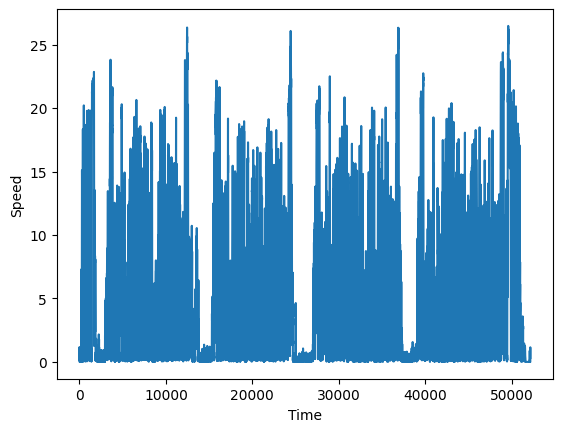

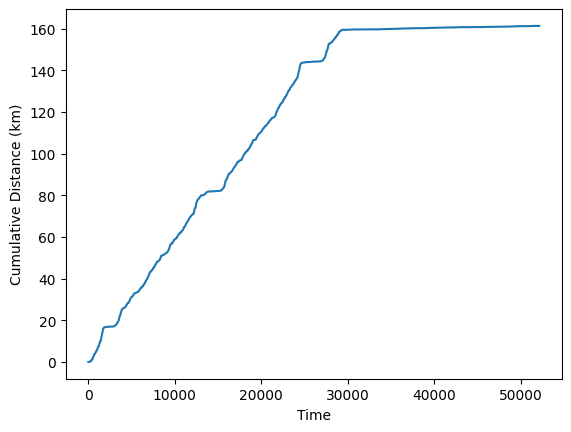

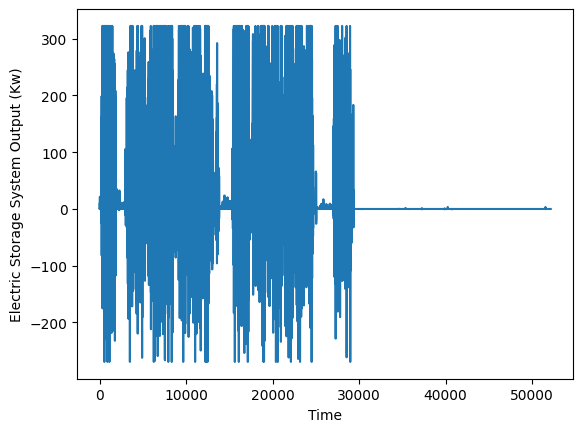

In [7]:
output = results['AB03/0520']
df = pd.DataFrame.from_dict(output)

time_range = range(0,len(df))
extents = detect_stops(df, time_range)
print('extents', extents)
# TODO plot horizontal lines of the extents

# Visualize range
df = df[time_range.start:time_range.stop]
plt.plot(df['time'],df['speed'])
plt.xlabel('Time')
plt.ylabel('Speed')
plt.show()

plt.plot(df['time'],df['cumDistKm'])
plt.xlabel('Time')
plt.ylabel('Cumulative Distance (km)')
plt.show()

plt.plot(df['time'], df['essKwOutAch'])
plt.xlabel('Time')
plt.ylabel('Electric Storage System Output (Kw)')
plt.show()       

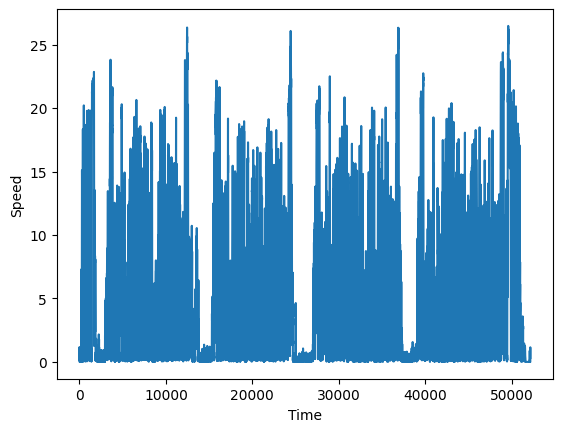

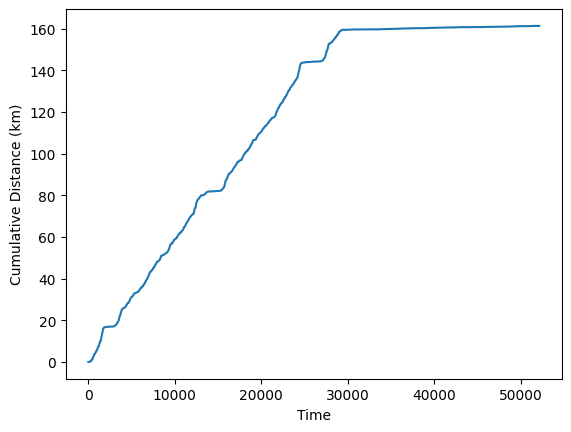

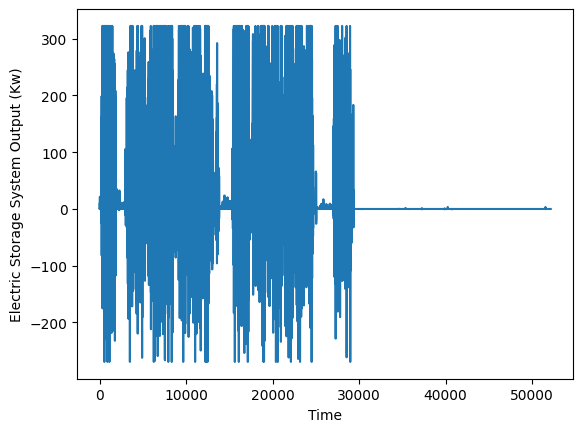

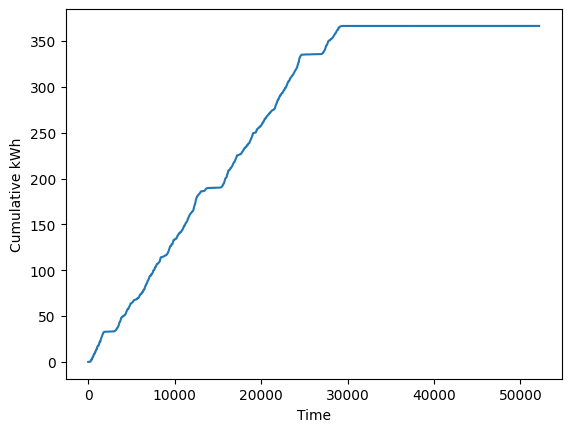

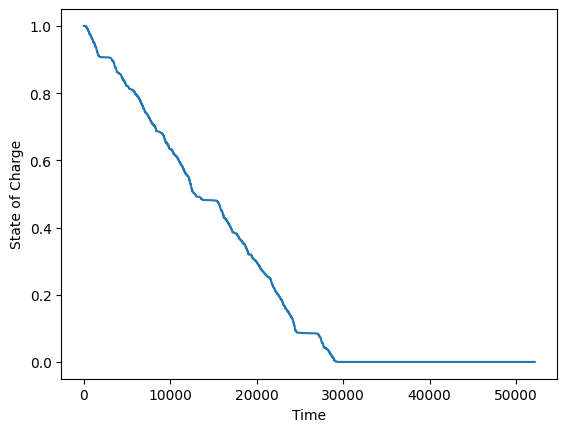

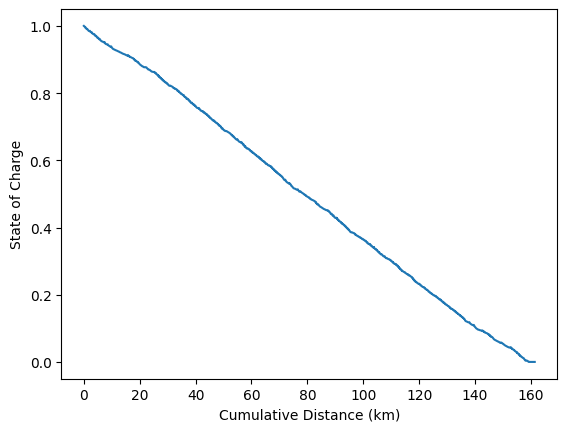

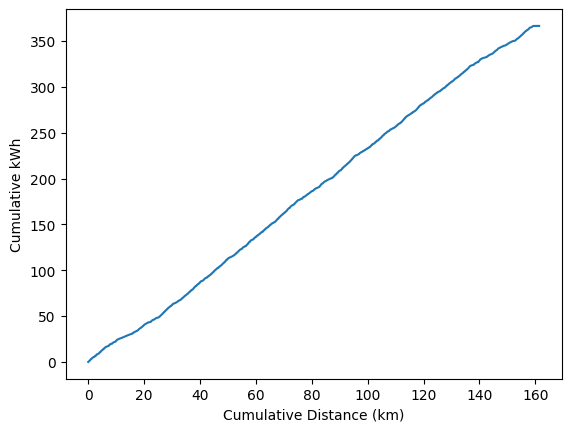

In [ ]:
# Visualize
df = pd.DataFrame.from_dict(output)

# plt.rcParams['figure.figsize'] = [30, 20]

plt.plot(df['time'],df['speed'])
plt.xlabel('Time')
plt.ylabel('Speed')
plt.show()

plt.plot(df['time'],df['cumDistKm'])
plt.xlabel('Time')
plt.ylabel('Cumulative Distance (km)')
plt.show()

plt.plot(df['time'], df['essKwOutAch'])
plt.xlabel('Time')
plt.ylabel('Electric Storage System Output (Kw)')
plt.show()

plt.plot(df['time'], df['cumKwh'])
plt.xlabel('Time')
plt.ylabel('Cumulative kWh')
plt.show()

plt.plot(df['time'],df['soc'])
plt.xlabel('Time')
plt.ylabel('State of Charge')
plt.show()

plt.plot(df['cumDistKm'],df['soc'])
plt.xlabel('Cumulative Distance (km)')
plt.ylabel('State of Charge')
plt.show()

plt.plot(df['cumDistKm'], df['cumKwh'])
plt.xlabel('Cumulative Distance (km)')
plt.ylabel('Cumulative kWh')
plt.show()

In [14]:
print('Simulation summary:')
print(f'Final S.O.C.: {output["final_soc"]*100:.2f} %')
print(f'Distance driven: {output["distance_mi"]:.2f} miles. {output["distance_mi"]*utils.km_per_mile:.2f} km')
print(f'Total time driven (if battery didn\'t run out): {df["time"].iloc[-1] * 1/3600:.2f} hours')
print(f'Total energy required: {df["cumKwh"].iloc[-1]:.2f} kWh')
# TODO: How can the cumulative kwh exceed the max capacity of the battery?

Simulation summary:
Final S.O.C.: 0.00 %
Distance driven: 100.29 miles. 161.41 km
Total time driven (if battery didn't run out): 14.49 hours
Total energy required: 366.52 kWh


# Exploring LOGIOS' Graphs
Exploring the relationship between 'discriminated consumption' and 'energy available' graphs for each route in LOGIOS' "Deliverable 4 Energy Consumption Projection" report.

## AB03: Discriminated Consumption (Fig. 2) vs Energy Available (Fig. 4)

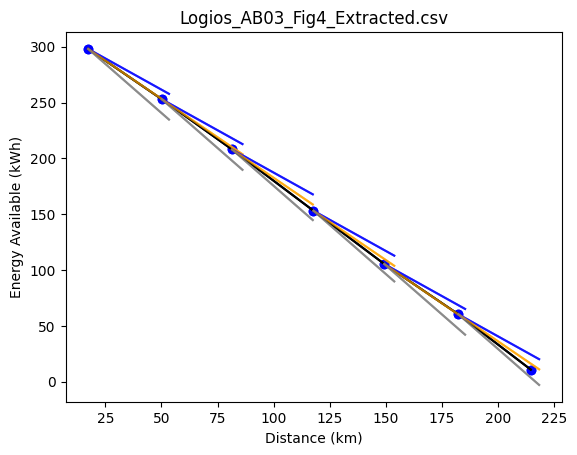

Energy-Available Graph consumption rates per segment:
[Segment 1] start:  17.3 km.  dist: 32.8 km.  energy: -45.0 kWh
[Segment 2] start:  50.1 km.  dist: 31.3 km.  energy: -45.0 kWh
[Segment 3] start:  81.4 km.  dist: 36.3 km.  energy: -54.9 kWh
[Segment 4] start: 117.7 km.  dist: 31.6 km.  energy: -47.7 kWh
[Segment 5] start: 149.3 km.  dist: 33.0 km.  energy: -45.0 kWh
[Segment 6] start: 182.3 km.  dist: 32.3 km.  energy: -49.5 kWh


In [13]:
# Given an inital point x0,y0, line slope m, second x value x1, compute y1.
def y(x, m, x0, y0):
    return m*(x-x0) + y0

def compare_logios_graphs_for_route(disc_consump_file, energy_avail_file):
    DISC_CONSUMPT_DIR = '../Data/LOGIOS Data/Report 4 Extracts/Discriminated Consumption'
    df = pd.read_csv(Path(DISC_CONSUMPT_DIR) / disc_consump_file)
    # The energy consumption slopes (kWh/km) of the 3 discriminated consumptions rates
    dc_dist = df.x[0]
    # Baseline
    base_m = -df.y[0] / df.x[0]
    # Baseline + Passengers
    base_pass_m = -df.y[1] / df.x[1]
    # Baseline + Passengers + HVAC
    base_pass_hvac_m = -df.y[2] / df.x[2]

    ENERGY_AVAILABLE_DIR = '../Data/LOGIOS Data/Report 4 Extracts/Energy Available'
    df = pd.read_csv(Path(ENERGY_AVAILABLE_DIR) / energy_avail_file)
    plt.plot(df.x, df.y, color='black')
    plt.scatter(df.x, df.y, color='blue')

    # Overlay discriminated consumption rates
    # For each segment, show what the energy burn-down would be at the rates depicted in the
    # respective discriminated consumption graph (e.g. fig 2)
    for i in range(len(df)-1):
        # Base
        x0, y0 = df.x[i], df.y[i]
        x1 = df.x[i] + dc_dist
        plt.plot([x0, x1], [y0, y(x1, base_m, x0, y0)], color='blue', alpha=0.7)
        plt.plot([x0, x1], [y0, y(x1, base_pass_m, x0, y0)], color='orange', alpha=0.7)
        plt.plot([x0, x1], [y0, y(x1, base_pass_hvac_m, x0, y0)], color='gray', alpha=0.7)
        # TODO: Or should each segment's dx be 36, to capture ?

    plt.title(f'{energy_avail_file}')
    plt.xlabel(f'Distance (km)')
    plt.ylabel(f'Energy Available (kWh)')
    plt.show()

    print(f'Energy-Available Graph consumption rates per segment:')
    for i in range(1, len(df)):
        # Distance Travelled
        dx = df.x[i] - df.x[i-1]
        # Energy consumed
        de = df.y[i] - df.y[i-1]
        print(f"[Segment {i}] start: {df.x[i-1]:5.01f} km.  dist: {dx:3.01f} km.  energy: {de:5.01f} kWh")
        
disc_consump_file = 'Logios_AB03_Fig2_Extracted.csv'
energy_avail_file = 'Logios_AB03_Fig4_Extracted.csv'
compare_logios_graphs_for_route(disc_consump_file, energy_avail_file)

## TC08: Discriminated Consumption (Fig. 11) vs Energy Available (Fig. 13)

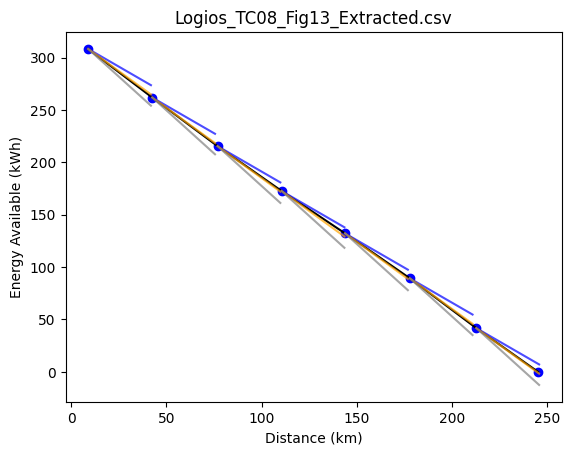

Energy-Available Graph consumption rates per segment:
[Segment 1] start:   8.8 km.  dist: 33.7 km.  energy: -46.4 kWh
[Segment 2] start:  42.5 km.  dist: 34.3 km.  energy: -46.4 kWh
[Segment 3] start:  76.9 km.  dist: 33.7 km.  energy: -42.9 kWh
[Segment 4] start: 110.6 km.  dist: 33.4 km.  energy: -40.5 kWh
[Segment 5] start: 143.9 km.  dist: 34.0 km.  energy: -42.9 kWh
[Segment 6] start: 177.9 km.  dist: 35.0 km.  energy: -47.6 kWh
[Segment 7] start: 212.9 km.  dist: 32.4 km.  energy: -41.7 kWh


In [15]:
disc_consump_file = 'Logios_TC08_Fig11_Extracted.csv'
energy_avail_file = 'Logios_TC08_Fig13_Extracted.csv'
compare_logios_graphs_for_route(disc_consump_file, energy_avail_file)

These comparisons of graphs for AB03 and TC08 hint that Logios may have mislabeled their 'Energy Available' graphs (e.g. Figures 4 and 13). Though they label them as illustrating the energy consumption with passengers and HVAC, it looks more like they do not include the HVAC consumption. 